In [1]:
import os
import xarray as xr
import pandas as pd
import netCDF4 as nc
from pathlib import Path
# from natsort import natsorted
import matplotlib.pyplot as plt
import gc
import os 
from os.path import exists
import dask_labextension
import numpy as np
import gsw
import cmocean.cm as cm

In [2]:
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm

In [3]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)


xgcm version 0.8.2.dev15+g7492277 
regionate version 0.0.1 
xwmt version 0.1.1 
xwmb version 0.1.1


In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='192GB',
    walltime='02:00:00',
    queue='scavenger',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=16)
from dask.distributed import Client
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=179G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.125:45852 --name dummy-name --nthreads 36 --memory-limit 178.81GiB --nanny --death-timeout 60 --interface ib0



In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.125:45852,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/" + x

In [34]:
ds = xr.open_mfdataset(
        datadir("budget_diagnostics/CM4Xp125_budgets_sigma2_2025-2029.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1, "time":-1},
        engine="zarr")

sigma2_i = (ds.sigma2_l.values[1:] + ds.sigma2_l.values[0:-1])/2
ds = ds.assign_coords({"sigma2_i":np.concatenate(([-100.], sigma2_i, [100.]))})

In [35]:
ds = ds.fillna(0.0)

In [36]:
Zprefix = "sigma2_"

coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'},
}

metrics = {
    ('X','Y'): "areacello",
}

boundary = {"X":"extend", "Y":"extend", "Z":"extend"}

grid = xgcm.Grid(ds, coords=coords, metrics=metrics, boundary=boundary, autoparse_metadata=False)

In [37]:
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid, budgets_dict)

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


(53.0, 66.0)

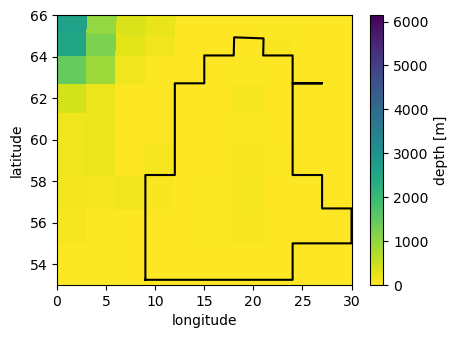

In [38]:
# Note: the properties of this region are quite different from the rest of the Baltic!
name = "intBaltic"
lons = np.array([8.,   20.,  29., 24.5, 24.5, 26.1, 17.5, 11.5])
lats = np.array([53.5, 53.5, 54.5,  59.,  61.,  63., 64.5,  62.])
region = regionate.GriddedRegion(name, lons, lats, grid)

plt.figure(figsize=(4.75,3.5))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    grid._ds['deptho'],
    cmap="viridis_r"
)
plt.colorbar(pc, label="depth [m]")
plt.plot(regionate.loop(region.lons), regionate.loop(region.lats), color="k");
plt.xlabel("longitude");
plt.ylabel("latitude");
plt.xlim(0, 30)
plt.ylim(53, 66)

In [39]:
import warnings

lam = "sigma2"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        region
    )
    wmb.mass_budget(lam)
    wmb.wmt.load()
    wmt = wmb.wmt

In [40]:
import matplotlib.pyplot as plt

def hovmoller(wmt, var, robust=False, units="kg", **kwargs):
    da = wmt[var]
    if robust:
        vmax = np.abs(da).quantile(0.95).compute()
        kwargs["vmin"] = -vmax
        kwargs["vmax"] = vmax

    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    time_idx_bounds = xr.DataArray(np.arange(0, wmt.time_bounds.size), dims=('time_bounds',))
    pc = plt.pcolor(
        time_idx_bounds,
        coord_bounds,
        da.transpose() if da.dims[0] == "time" else da,
        **kwargs
    )

    dtick = da.time.size//12
    date_str = [f"{d.year}-{str(d.month).zfill(2)}-{str(d.day).zfill(2)}" for d in wmt["time_bounds"].values[::dtick]]
    plt.xticks(time_idx_bounds[::dtick], date_str, rotation=90)
    plt.colorbar(label=f"transformation rate [{units}]")
    for coord_bound in coord_bounds:
        plt.axhline(coord_bound, color="k", lw=0.25)
    
    return pc

def stairs(wmt, var, units="kg", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = plt.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    plt.xlabel(f"mean transformation rate [{units}]")
    return l

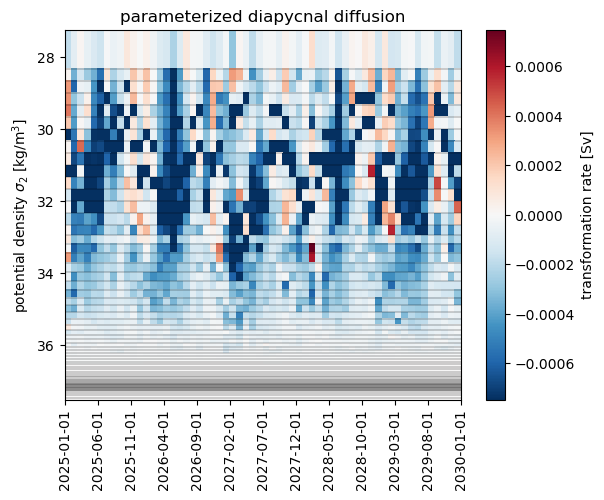

In [41]:
toSv = 1.e-6/wmb.rho_ref
pc = hovmoller(wmt.isel(exp = 0)*toSv, "diffusion", cmap="RdBu_r", units="Sv", robust=True)
plt.ylim(37.5, 27.25);
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.title("parameterized diapycnal diffusion");

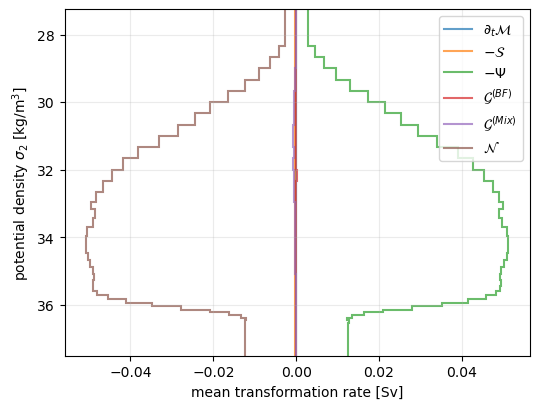

In [42]:
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

wmt_mean = wmt.isel(exp = 0).mean('time')*toSv
stairs( wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$",**kwargs)
stairs(-wmt_mean, 'mass_source',               label=r"$-\mathcal{S}$",            **kwargs)
stairs(-wmt_mean, 'convergent_mass_transport', label=r"$-\Psi$",                   **kwargs)
stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$",      **kwargs)
stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{N}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim( 37.5, 27.25,);